In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.profiler import profile, record_function, ProfilerActivity
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import time
import os


In [2]:
# Ensure output folders
os.makedirs("log", exist_ok=True)
os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)



In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT and Tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()




2025-05-08 18:28:23.311557: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 18:28:24.913452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746743305.477472    6838 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746743305.621649    6838 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746743307.009015    6838 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [4]:
# Load GLUE SST-2 and take a small batch
glue_data = load_dataset("glue", "sst2", split="validation[:16]")
texts = glue_data["sentence"]

# Tokenize input
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)

# Warm-up
with torch.no_grad():
    for _ in range(5):
        _ = model(**inputs)


In [5]:
# Profile the model
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    with_stack=False
) as prof:
    with torch.no_grad():
        for _ in range(10):
            with record_function("inference"):
                _ = model(**inputs)


In [6]:
# Export trace for Chrome
trace_filename = f"log/glue_trace_{int(time.time())}.json"
prof.export_chrome_trace(trace_filename)
print(f"Chrome trace saved to: {trace_filename}")


Chrome trace saved to: log/glue_trace_1746743331.json


In [7]:
key_averages = prof.key_averages()
rows = []
for row in key_averages:
    rows.append({
        "Name": row.key,
        "Self CPU time total (ms)": row.self_cpu_time_total / 1000,
        "CPU total time (ms)": row.cpu_time_total / 1000,
        "Calls": row.count
    })

df = pd.DataFrame(rows)
df = df.sort_values(by="CPU total time (ms)", ascending=False)
df.reset_index(drop=True, inplace=True)


# Save table as CSV
df.to_csv("tables/profiler_summary.csv", index=False)
print("Saved profiler summary to tables/profiler_summary.csv")

Saved profiler summary to tables/profiler_summary.csv


In [8]:
# Print top 10 ops to console
!pip install tabulate --user
print(df.head(10).to_markdown(index=False))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


| Name                                          |   Self CPU time total (ms) |   CPU total time (ms) |   Calls |
|:----------------------------------------------|---------------------------:|----------------------:|--------:|
| inference                                     |                   65.6238  |             177.667   |      10 |
| aten::linear                                  |                    6.5493  |              57.939   |     740 |
| aten::addmm                                   |                   24.6838  |              40.1341  |     740 |
| aten::layer_norm                              |                    3.2005  |              14.6517  |     250 |
| cudaLaunchKernel                              |                   13.7831  |              13.7831  |    1600 |
| aten::native_layer_norm                       |                    5.1616  |              11.4512  |     250 |
| aten::scaled_dot_product_attention            |                    1.8248  |              10.8

Saved CUDA timing plot to figures/cuda_kernel_timing.png


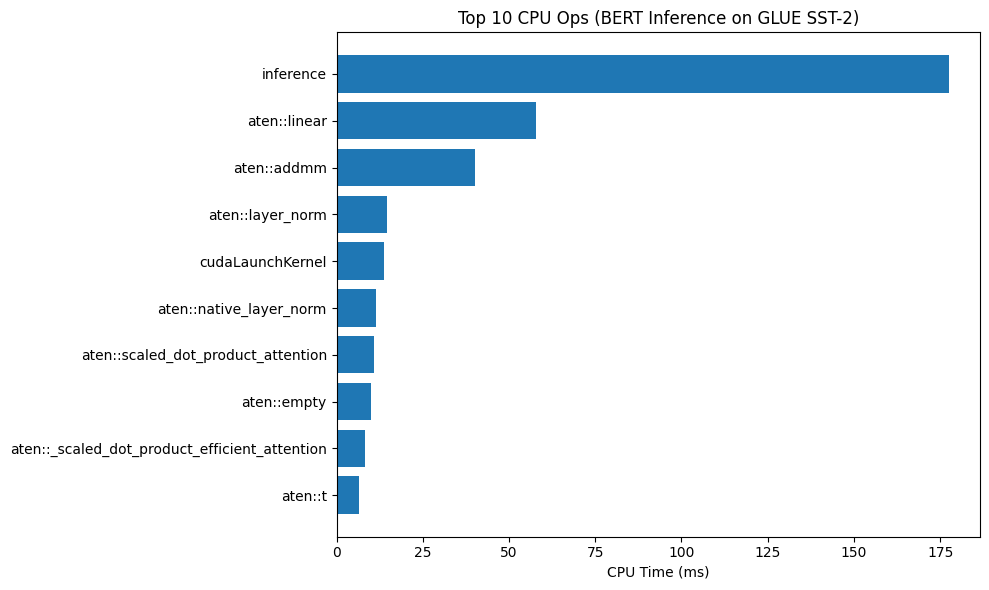

In [9]:
# Plot top 10 CUDA ops
top_ops = df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_ops["Name"], top_ops["CPU total time (ms)"])
plt.xlabel("CPU Time (ms)")
plt.title("Top 10 CPU Ops (BERT Inference on GLUE SST-2)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/cuda_kernel_timing.png")
print("Saved CUDA timing plot to figures/cuda_kernel_timing.png")

In [10]:
import torch
from transformers import AutoModelForSequenceClassification
from typing import NamedTuple

class Output(NamedTuple):
    logits: torch.Tensor

class WrappedBERT(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_ids, attention_mask):
        logits = self.model(input_ids=input_ids, attention_mask=attention_mask).logits
        return Output(logits=logits)

# Load and wrap model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased").eval()
wrapped = WrappedBERT(model)

# Dummy inputs
input_ids = torch.randint(0, 1000, (1, 128), dtype=torch.int64)
attention_mask = torch.ones_like(input_ids)

# Trace with NamedTuple output
traced = torch.jit.trace(wrapped, (input_ids, attention_mask), strict=False)
traced.save("bert_export/bert/1/model.pt")
print("✅ Traced and saved with NamedTuple output.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


✅ Traced and saved with NamedTuple output.


In [11]:
import numpy as np
import tritonclient.http as httpclient
from transformers import AutoTokenizer
import time

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Prepare input text
texts = ["I love this movie!", "This was terrible."]
inputs = tokenizer(texts, padding="max_length", max_length=128, truncation=True, return_tensors="np")

# Triton client setup
url = "localhost:8000"  # If running locally
model_name = "bert"
client = httpclient.InferenceServerClient(url=url)

# Prepare input tensors
input_ids = inputs["input_ids"].astype(np.int64)
attention_mask = inputs["attention_mask"].astype(np.int64)

# Wrap in Triton infer inputs
infer_inputs = [
    httpclient.InferInput("input_ids", input_ids.shape, "INT64"),
    httpclient.InferInput("attention_mask", attention_mask.shape, "INT64")
]
infer_inputs[0].set_data_from_numpy(input_ids)
infer_inputs[1].set_data_from_numpy(attention_mask)

# Set expected output
outputs = [httpclient.InferRequestedOutput("logits")]

# Send inference request
start = time.time()
response = client.infer(model_name=model_name, inputs=infer_inputs, outputs=outputs)
end = time.time()

# Get and decode predictions
logits = response.as_numpy("logits")
print("Output logits:\n", logits)
print(f"Latency: {(end - start) * 1000:.2f} ms")



Output logits:
 [[-0.04206056  0.41311032]
 [ 0.00555348  0.29861367]]
Latency: 1223.45 ms


In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    ignore_mismatched_sizes=True  # suppress init weight warning
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import torch
import time
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import tritonclient.http as httpclient
from tritonclient.utils import np_to_triton_dtype

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load dataset
texts = load_dataset("glue", "sst2", split="validation[:4]")["sentence"]
inputs = tokenizer(texts, return_tensors="pt", padding="max_length", truncation=True, max_length=128).to(device)

# Prepare models
model_base = AutoModelForSequenceClassification.from_pretrained(model_name).to(device).eval()
model_dynamo = torch.compile(model_base, backend="inductor")

# Warm-up
for _ in range(5):
    _ = model_base(**inputs)
    _ = model_dynamo(**inputs)

# Benchmarking function
def benchmark(model, name, runs=50, warmup=5):
    torch.cuda.synchronize()
    # Warmup
    for _ in range(warmup):
        _ = model(**inputs)
        torch.cuda.synchronize()
    # Actual timing
    times = []
    with torch.no_grad():
        for _ in range(runs):
            start = time.time()
            _ = model(**inputs)
            torch.cuda.synchronize()
            times.append((time.time() - start) * 1000)
    return {
        "Engine": name,
        "Mean (ms)": round(np.mean(times), 2),
        "Median (ms)": round(np.median(times), 2),
        "P95 (ms)": round(np.percentile(times, 95), 2),
        "Min (ms)": round(np.min(times), 2),
        "Max (ms)": round(np.max(times), 2)
    }

# Triton benchmark
def triton_inference(runs=50, warmup=5):
    client = httpclient.InferenceServerClient("localhost:8000")

    input_ids = inputs["input_ids"].cpu().numpy()
    attention_mask = inputs["attention_mask"].cpu().numpy()

    infer_input1 = httpclient.InferInput("input_ids", input_ids.shape, np_to_triton_dtype(np.int64))
    infer_input2 = httpclient.InferInput("attention_mask", attention_mask.shape, np_to_triton_dtype(np.int64))
    infer_input1.set_data_from_numpy(input_ids)
    infer_input2.set_data_from_numpy(attention_mask)

    times = []
    for _ in range(runs):
        start = time.time()
        response = client.infer(
            model_name="bert",
            inputs=[infer_input1, infer_input2]
        )
        _ = response.as_numpy("logits")  # fetch output
        times.append((time.time() - start) * 1000)

    return {
        "Engine": "Triton (NVIDIA Dynamo)",
        "Mean (ms)": round(np.mean(times), 2),
        "Median (ms)": round(np.median(times), 2),
        "P95 (ms)": round(np.percentile(times, 95), 2),
        "Min (ms)": round(np.min(times), 2),
        "Max (ms)": round(np.max(times), 2)
    }

# Run all benchmarks
results = [
    benchmark(model_base, "PyTorch Baseline"),
    benchmark(model_dynamo, "Torch.compile (Inductor)"),
    triton_inference()
]

# Save and print
df = pd.DataFrame(results)
df.to_csv("tables/inference_comparison.csv", index=False)
print("\n=== Inference Latency Comparison ===")
print(df.to_markdown(index=False))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Inference Latency Comparison ===
| Engine                   |   Mean (ms) |   Median (ms) |   P95 (ms) |   Min (ms) |   Max (ms) |
|:-------------------------|------------:|--------------:|-----------:|-----------:|-----------:|
| PyTorch Baseline         |       12.25 |         12.25 |      12.41 |      11.98 |      12.62 |
| Torch.compile (Inductor) |       12.13 |         12    |      12.8  |      11.63 |      13.89 |
| Triton (NVIDIA Dynamo)   |        9.42 |          9.34 |       9.52 |       9.25 |      11.75 |


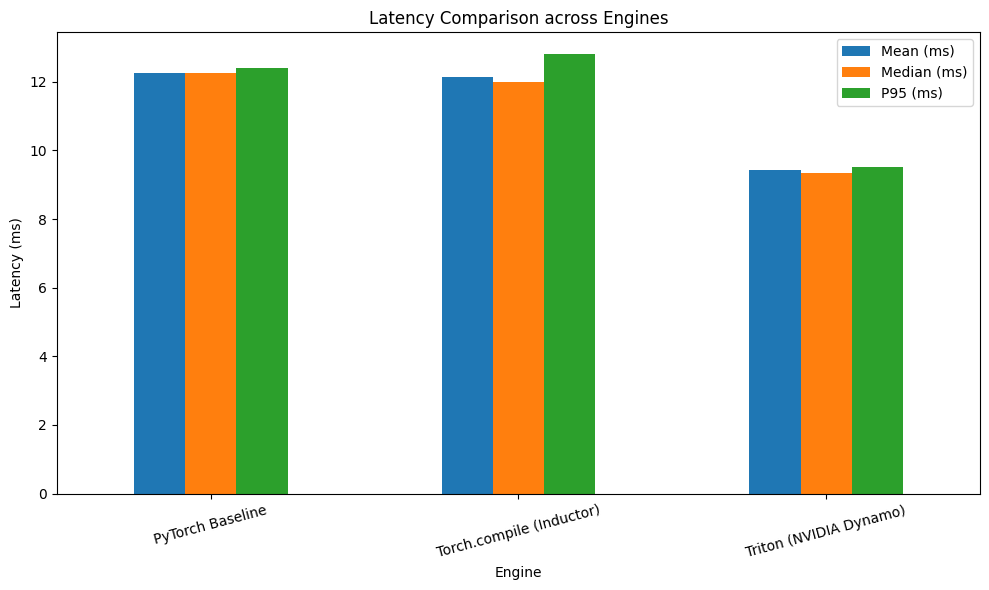

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
# Latency bar chart
df.plot(x="Engine", y=["Mean (ms)", "Median (ms)", "P95 (ms)"], kind="bar", figsize=(10,6))
plt.title("Latency Comparison across Engines")
plt.ylabel("Latency (ms)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("figures/latency_comparison_bar.png")
plt.show()


/tmp/ipykernel_6838/1531641537.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


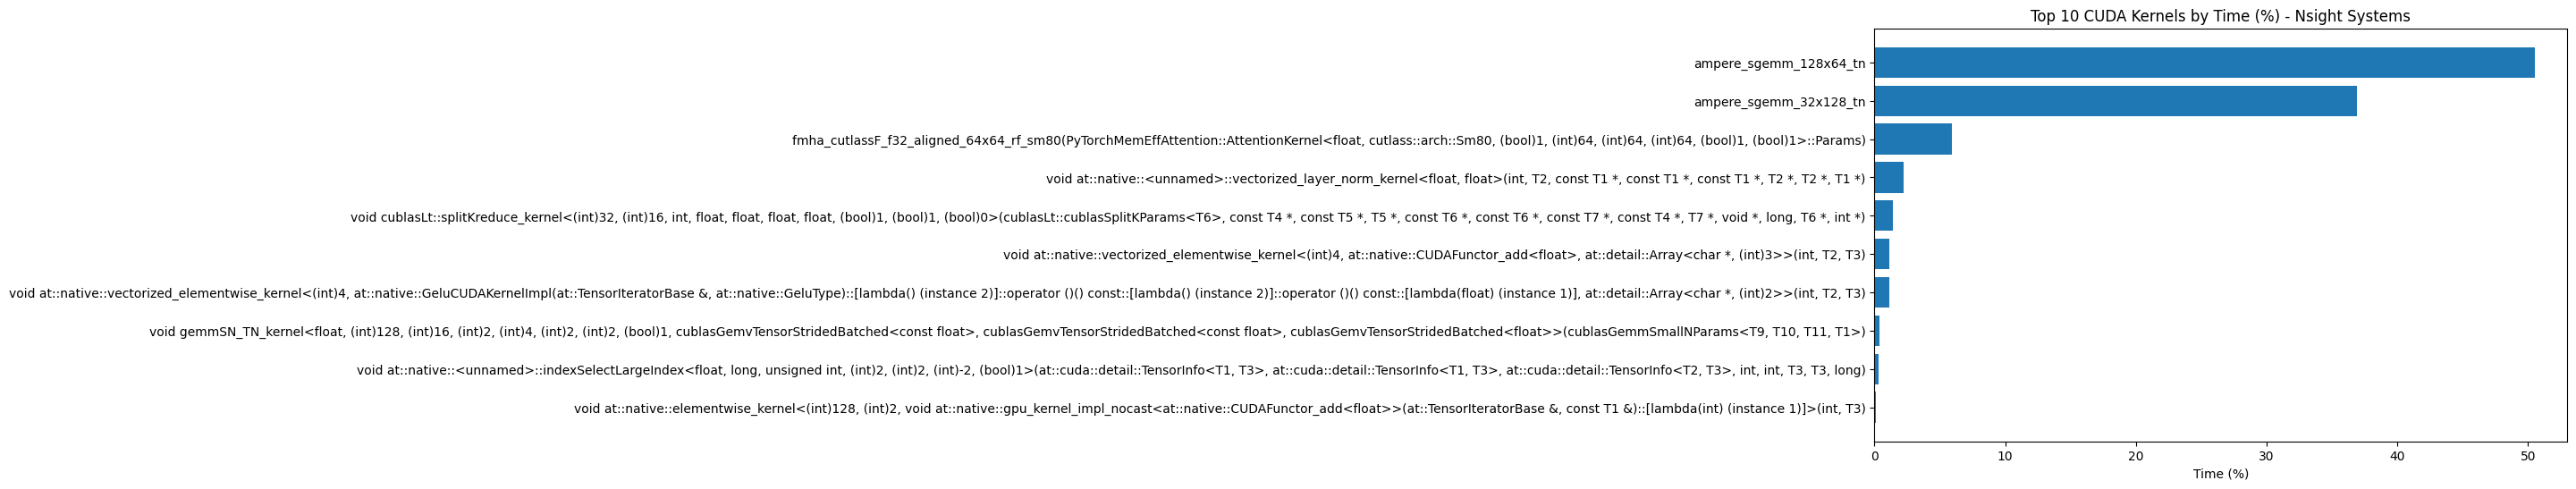

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Nsight CUDA kernel summary
df = pd.read_csv("triton_profile_summary_cuda_gpu_kern_sum.csv")

# Sort by total time percentage and select top 10 kernels
top_kernels = df.sort_values("Time (%)", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_kernels["Name"], top_kernels["Time (%)"])
plt.xlabel("Time (%)")
plt.title("Top 10 CUDA Kernels by Time (%) - Nsight Systems")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


/tmp/ipykernel_6838/1371717435.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


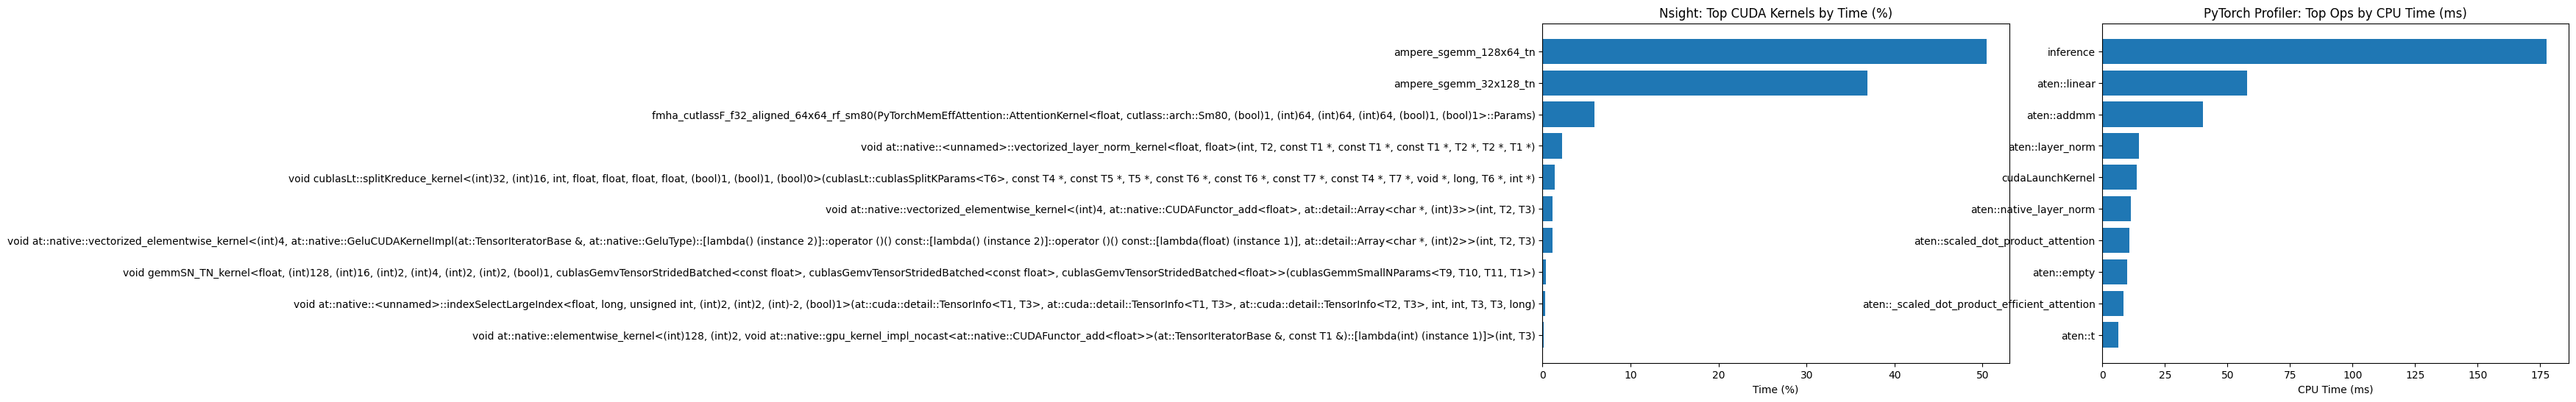

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Nsight GPU kernel summary
nsight_df = pd.read_csv("triton_profile_summary_cuda_gpu_kern_sum.csv")
top_nsight = nsight_df.sort_values("Time (%)", ascending=False).head(10)

# Load PyTorch profiler operator summary
torch_df = pd.read_csv("tables/profiler_summary.csv")
top_torch = torch_df.sort_values("CPU total time (ms)", ascending=False).head(10)

# Prepare subplot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Nsight plot
axes[0].barh(top_nsight["Name"], top_nsight["Time (%)"])
axes[0].set_title("Nsight: Top CUDA Kernels by Time (%)")
axes[0].set_xlabel("Time (%)")
axes[0].invert_yaxis()

# PyTorch Profiler plot
axes[1].barh(top_torch["Name"], top_torch["CPU total time (ms)"])
axes[1].set_title("PyTorch Profiler: Top Ops by CPU Time (ms)")
axes[1].set_xlabel("CPU Time (ms)")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [23]:
fig.savefig("figures/kernel_vs_op_timing.png", dpi=300)

In [26]:
total_nsight_time = nsight_df["Total Time (ns)"].sum()
top_kernels_time = top_nsight["Total Time (ns)"].sum()
percent_covered = (top_kernels_time / total_nsight_time) * 100
print(f"Top 10 kernels account for {percent_covered:.2f}% of GPU time")


Top 10 kernels account for 99.76% of GPU time


⚙️ Torch.compile is 1.01× faster than PyTorch baseline
⚙️ Triton (Dynamo) is 1.30× faster than PyTorch baseline


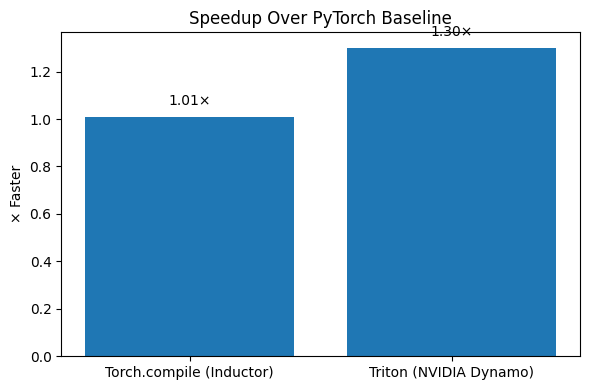

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your saved latency CSV
df = pd.read_csv("tables/inference_comparison.csv")

# Extract mean latencies
baseline_mean = df[df["Engine"] == "PyTorch Baseline"]["Mean (ms)"].values[0]
dynamo_mean = df[df["Engine"] == "Torch.compile (Inductor)"]["Mean (ms)"].values[0]
triton_mean = df[df["Engine"] == "Triton (NVIDIA Dynamo)"]["Mean (ms)"].values[0]

# Compute speedups
speedup_dynamo = baseline_mean / dynamo_mean
speedup_triton = baseline_mean / triton_mean

# Print results
print(f"⚙️ Torch.compile is {speedup_dynamo:.2f}× faster than PyTorch baseline")
print(f"⚙️ Triton (Dynamo) is {speedup_triton:.2f}× faster than PyTorch baseline")

# Plot speedups
engines = ["Torch.compile (Inductor)", "Triton (NVIDIA Dynamo)"]
speedups = [speedup_dynamo, speedup_triton]

plt.figure(figsize=(6, 4))
bars = plt.bar(engines, speedups)
plt.title("Speedup Over PyTorch Baseline")
plt.ylabel("× Faster")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{yval:.2f}×", ha='center')
plt.tight_layout()
plt.show()
